*** THEORY ***

Input:

$p$: user preference for some attribute of another user, $p\in{[0,1]}$, where 0 means total indifference and 1 means total preference. For example, $p=1$ could mean that the user only wants to date people of the same race.<br>
$b$: decision boundary threshold for classification (by default, $b=0.5$)<br>
$C$: set of all candidates for recommendation <br>
$S$: recommendation set, $S\subseteq{C}$, such that $x \ge b, \forall{x \in S} $<br>

The fairness of a recommender system is defined as follows: <br> 
For a user with weak preference $p=0$, the fair recommender system must produce a recommendation set whose mean is 'calibrated' to the distribution of the candidate set, i.e. $\mu^{*} = \mu_{C}$. <br> 
For a user with strong preference $p=1$, the fair recommender system must produce a set containing items with the highest values of a sensitive attribute, i.e. $\mu^{*} = \mu_{max}$. <br>
This gives the following formula for the optimal mean given a user preference $p$ and a size of the recommendation set $|S|$:

$\mu^{*} = \mu_{C} + p*(\mu_{max} - \mu_{C})$

The absolute error for the recommendation set $S$ is defined as $\delta_{S} = |\mu^{*} - \mu_{S}|$.
To calculate the relative (un)fairness measure, we first calculate $\delta_{min}$ and $\delta_{max}$ for a given size $|S|$ and candidate set $C$: $\delta_{min} = \min_{\mu}|\mu^{*} - \mu|$, $\delta_{max} = \max_{\mu}|\mu^{*} - \mu|$, where $\mu$ values are taken over all possible combinations of size $|S|$.

The fairness error $\epsilon$ taking values from 0 (total fairness) to 1 (total unfairness) is simply a scaled absolute error:

$\epsilon = \frac{\delta_{S}-\delta_{min}}{\delta_{max}-\delta_{min}}$.

We can represent it as a fairness percentage score: $\phi = 100 * (1 - \epsilon)$.

The above measure quantifies <i>algorithmic fairness</i> by penalizing suboptimal solutions for a given set size. It ensures that for each size, there is always at least one optimal way to act.

Let's take an example.


In [66]:
import numpy as np
import time
import sys, os
sys.path.insert(0, os.path.abspath('..'));
from algorithms.exhaustive import Exhaustive
from algorithms.greedy import Greedy
import metrics.rank
from metrics.epsilon import Epsilon
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from scipy import stats
import itertools

# Example

scores_cand = np.array([0.9,0.8,0.7,0.6,0.40,0.30,0.20,0.10]) # Item prediction scores produced by a recommender system
attr_cand = np.array([0,0,1,0,0,1,1,1]) # Sensitive attribute values associated with each item (e.g. if partner is of the same race)
pref = 0 # Weak preference -> The rec. set and the candidate set should have the same proportions of sensitive attribute
b = 0.5 # Decision boundary

# Create a recommendation set from a candidate set based on the decision boundary
rec_ids = np.nonzero(scores_cand >= b)
scores_rec = scores_cand[rec_ids]
attr_rec = attr_cand[rec_ids]

# Measure the fairness of the recommendation set
e = Epsilon(pref, attr_cand, attr_rec) 
print ('epsilon: {0:.2f}'.format(e.score()))

epsilon: 0.50


The above $\epsilon$ shows that the recommendation set is only half-fair, since a positive value of a sensitive attribute is underrepresented in recommendations (only one '1' appears in recommendation set [0,0,1,0]). To become fair under pref = 0, the recommendation set must contain equal number of 0s and 1s, since this conforms with the distribution of a candidate set, whose mean is $4/8=0.5$. Let's draw the fairness curves for three different values of preference: p=0, p=0.5, and p=1.


--------------- [pref = 0.0] ---------------

{'m_star': 0.5, 'delta': 0.25, 'epsilon': 0.5}

--------------- [pref = 0.5] ---------------

{'m_star': 0.75, 'delta': 0.5, 'epsilon': 0.6667}

--------------- [pref = 1.0] ---------------

{'m_star': 1.0, 'delta': 0.75, 'epsilon': 0.75}


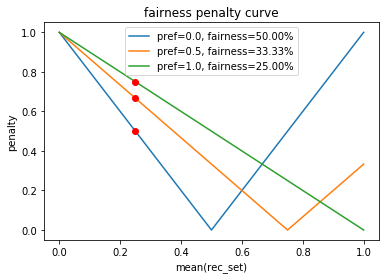

In [53]:
e.visualize(prefs=[0.0, 0.5, 1.0])

The chart above shows the position of a given recommendation set (red dots) on fairness curves for various preference values, as well as the means for which perfect fairness can be achieved (points where curves 'touch the floor'). For example, for pref=0, the mean of the recommendation set must be equal to 0.5, whereas for pref=1, its mean should be 1.

If a given recommendation set is not fair from the beginning, adjusting it for fairness (i.e. $\epsilon=0$) implies either deleting relevant item(s) from it, or adding irrelevant item(s) to it. Thus, fairness is inevitably traded off for accuracy. Below, we experiment with a greedy algorithm that optimizes this trade-off.

*** EXPERIMENT ***

This experiment produces random samples of prediction scores and sensitive attribute values for random preference values. The sizes of sets vary from 1 to 10. The goal is to find a subset that ensures fairness (i.e. $\epsilon=0$), while maximizing the relevance of its items for the user. In its simplest form, the relevance of a set is expressed as the sum of prediction scores associated with its elements. In our experiment, we combine it with the deviation from the size of the original set (since this implies loss in precision or recall). I'll omit the details.

We consider two approaches: an exhaustive search that produces the global optimum, and a greedy algorithm.
Let's run the experiment, where for each considered set size we report the average over multiple runs of the simulation. We can also specify the $\alpha$ parameter, which controls the tolerance for (un)fairness. $\alpha=0$ means that we want to find a subset that is 100% fair.

In [54]:
# Settings
np.random.seed = 100
runs = 100
start_size = 1
end_size = 10
alpha = 0 # Fairness tolerance threshold. Takes values from 0 (total enforcement) to 1 (total indifference).
b = 0.5
np.set_printoptions(precision=2)

In [55]:
# Create a sample
def sample(size, b):
    scores = np.sort(np.random.rand(size))
    if max(scores) < b:
        return sample(size, b)
    attr = np.random.randint(0, 2, size)
    pref = np.random.rand()
    return scores, attr, pref

In [56]:
# Set output format
def plot(df, title, ylim=None, logy=False):
    print('\n---------------')
    print(title)
    print('---------------')
    marker = itertools.cycle(('o','x','+', ',', '.')) 
    for column in df:
        if column == 'Size':
            size = df[column]
        else:
            means = np.mean(df[column].tolist(), axis=1)
            print('means({0}): {1}'.format(column, means))
            stderr = stats.sem(df[column].tolist(), axis=1)
            plt.plot(size, means, marker = next(marker), label=column)
            plt.fill_between(size, means-stderr, means+stderr, alpha=0.1)
    if logy:
        plt.yscale('log')
        plt.gca().yaxis.set_major_formatter(ScalarFormatter()) # remove scientific notation
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(loc='best')
    plt.xlabel('Size')
    plt.title(title)
    plt.grid(alpha=0.5)
    plt.show()  

The greedy algorithm used in this simulation is a variant of a hill-climbing algorithm where we start with the initial solution (the original recommendation set), and then greedily choose an item to delete, insert, or substitute. A feasible operation which yields a set with the highest relevance is then executed. We perform these steps until we obtain a fair set. The exhaustive search looks at all possible combinations of items (for a given set size), and chooses a fair set that maximizes relevance. Let's run the simulation to obtain results from both approaches.

In [67]:
# Perform simulation
sim_data = []
glob_opt_data = []
time_data = []
f1_data = []
for size in range(start_size, end_size+1):
    sim_greedy = np.zeros(runs)
    sim_lower_bound = np.zeros(runs)
    time_greedy = np.zeros(runs)
    time_exhaustive = np.zeros(runs)
    f1_greedy = np.zeros(runs)
    f1_exhaustive = np.zeros(runs)
    f1_lower_bound = np.zeros(runs)
    for run in range(runs):
        print("\rsize {0} run {1}... ".format(size, run+1), end="", flush=True)
        scores, probsame, pref = sample(size, b)
        rec_set = scores[np.argmax(scores >= b):]
        # Run exhaustive search to obtain global optimum
        alg_exhaustive = Exhaustive(scores, probsame, b, rel_func=lambda w,s: w*s)
        start = time.time()
        rec_exhaustive, lower_bound = alg_exhaustive.run(pref, alpha)
        time_exhaustive[run] = (time.time()-start)*1000
        # Run greedy search
        alg_greedy = Greedy(scores, probsame, b, rel_func=lambda w,s: w*s)
        start = time.time()
        rec_greedy = alg_greedy.run(pref, alpha)
        time_greedy[run] = (time.time()-start)*1000
        # Calculate F1 of the resulting set relative to the original recommendation set
        f1_greedy[run] = metrics.rank.f1(rec_set, rec_greedy)
        f1_exhaustive[run] = metrics.rank.f1(rec_set, rec_exhaustive)
        f1_lower_bound[run] = metrics.rank.f1(rec_set, lower_bound)
        # Calculate the similarity of the resulting set to the original recommendation set
        sim_greedy[run] = metrics.rank.dice_similarity(rec_exhaustive, rec_greedy)
        sim_lower_bound[run] = metrics.rank.dice_similarity(rec_exhaustive, lower_bound)
    print('done')
    # Calculate the global optimum rate for the greedy solution
    glob_opt_greedy = np.where(sim_greedy < 1.0, 0, 1)
    sim_data.append((size, sim_greedy, sim_lower_bound))
    glob_opt_data.append((size, glob_opt_greedy))
    time_data.append((size, time_greedy, time_exhaustive))
    f1_data.append((size, f1_greedy, f1_exhaustive, f1_lower_bound))


size 1 run 100... done
size 2 run 100... done
size 3 run 100... done
size 4 run 100... done
size 5 run 100... done
size 6 run 100... done
size 7 run 100... done
size 8 run 100... done
size 9 run 100... done
size 10 run 100... done


First, we measure the similarity of the greedily obtained solution to the globally optimal solution for each set size using Dice similarity.


---------------
Dice similarity
---------------
means(Greedy): [1.   1.   0.99 0.98 0.96 0.96 0.96 0.97 0.95 0.96]
means(Lower bound): [1.   0.47 0.36 0.28 0.22 0.23 0.21 0.2  0.26 0.28]


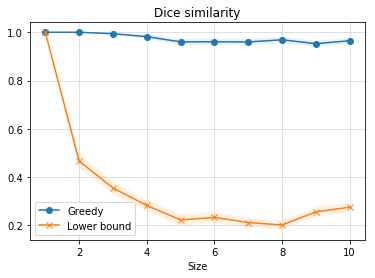

In [68]:
# Plot Dice similarity of greedy solution to the global optimum
plot(pd.DataFrame(sim_data, columns=('Size', 'Greedy', 'Lower bound')), 'Dice similarity')

We can see that the produced solutions are all very similar to globally optimal ones, with similarity above 95%. We see that greedy solutions are very far away from the lower bound that yields fair sets of low relevance.

Next, we plot a similar chart that shows the percentages of reaching globally optimal solutions using greedy optimization.


---------------
Global optimum rate
---------------
means(Greedy): [1.   1.   0.97 0.94 0.92 0.86 0.88 0.91 0.82 0.85]


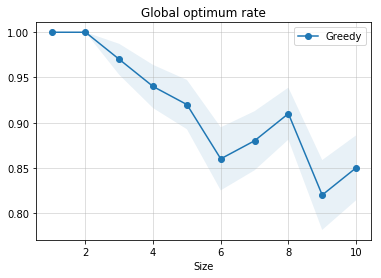

In [69]:
# Plot the global optimum rate of the greedy solution
plot(pd.DataFrame(glob_opt_data, columns=('Size', 'Greedy')), 'Global optimum rate')

Naturally, the chance of hitting the global optimum decreases with increasing size of the set. However, the percentage remains high.

Next, we plot the running time of two approaches to show how faster the greedy solution is.


---------------
Running time (ms)
---------------
means(Greedy): [0.26 0.41 0.44 0.82 0.71 0.84 1.4  0.91 0.7  0.89]
means(Exhaustive): [ 0.29  0.69  1.43  2.7   4.45  8.06 18.89 26.86 33.01 53.6 ]


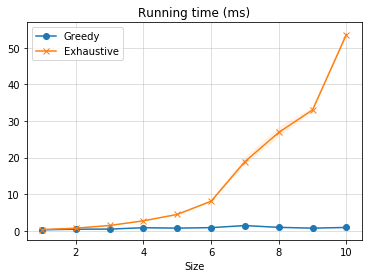

In [70]:
# Plot the running time of exhaustive and greedy algorithms
plot(pd.DataFrame(time_data, columns=('Size', 'Greedy', 'Exhaustive')), 
    'Running time (ms)')

As expected, the difference in running time is substantial.

The final plot depicts the loss in accuracy when fairness is enforced. We measure F1 score of the adjusted set relative to the original recommendation set, which is taken as the ground truth.


---------------
F1
---------------
means(Greedy): [1.   0.95 0.91 0.82 0.83 0.82 0.81 0.83 0.8  0.8 ]
means(Exhaustive): [1.   0.95 0.91 0.83 0.84 0.85 0.84 0.83 0.82 0.82]
means(Lower bound): [1.   0.36 0.28 0.17 0.17 0.18 0.15 0.15 0.18 0.18]


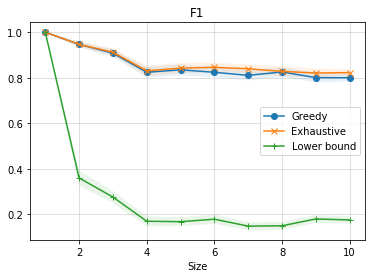

In [71]:
# Plot F1 with respect to the original recommendation set after re-ranking for fairness
plot(pd.DataFrame(f1_data, columns=('Size', 'Greedy', 'Exhaustive', 'Lower bound')), 'F1')

We can see that the mean of precision/recall (as captured by F1) is above 0.8, which is a decent accuracy considering that we enforce total fairness, and is well above the lower bound. We can also see that the greedy algorithm gives a good approximation of an exhaustive strategy.
The next promising approach will be to represent this as a Knapsack problem, and solve it using dynamic programming.